In [14]:
!pip install kagglehub[pandas-datasets]

In [15]:
# Install kagglehub (with pandas support)
!pip install kagglehub[pandas-datasets] --quiet

import kagglehub
from kagglehub import KaggleDatasetAdapter
import os

# Step 1: Download the dataset
# This will fetch the CelebA dataset from Kaggle
dataset_path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
print("Dataset downloaded to:", dataset_path)

# Step 2: Explore what files exist in the dataset
# (CelebA has images + annotation files)
for root, dirs, files in os.walk(dataset_path):
    for name in files[:10]:   # just show first 10 files
        print(os.path.join(root, name))
    break

# Step 3: Load annotation file into Pandas using KaggleHub
# The dataset includes "list_attr_celeba.csv" (attributes for each image)
attr_file = "list_attr_celeba.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "jessicali9530/celeba-dataset",
    attr_file
)

print("First 5 rows of attributes:")
print(df.head())

# Step 4 (Optional): Use images with PyTorch
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

celeba_dataset = datasets.ImageFolder(
    root=os.path.join(dataset_path, "img_align_celeba"),
    transform=transform
)

print("Number of images:", len(celeba_dataset))


Using Colab cache for faster access to the 'celeba-dataset' dataset.
Dataset downloaded to: /kaggle/input/celeba-dataset
/kaggle/input/celeba-dataset/list_landmarks_align_celeba.csv
/kaggle/input/celeba-dataset/list_eval_partition.csv
/kaggle/input/celeba-dataset/list_attr_celeba.csv
/kaggle/input/celeba-dataset/list_bbox_celeba.csv


/tmp/ipython-input-144049722.py:24: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'celeba-dataset' dataset.
First 5 rows of attributes:
     image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1       

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [30]:
class Discriminator(nn.Module):
  def __init__(self, channels_img, features_d):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        # Input: N x Channels_img x 64 x 64
        nn.Conv2d(
            channels_img, features_d, kernel_size=4, stride=2, padding=1
        ), # 32 x 32
        nn.LeakyReLU(0.2),
        self._block(features_d, features_d * 2, 4, 2, 1),
        self._block(features_d * 2, features_d * 4, 4, 2, 1),
        self._block(features_d * 4, features_d * 8, 4, 2, 1),
        nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=1, padding=0), # Adjusted for 1x1 output
        nn.Sigmoid(),
    )

  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False
        ),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),
    )

  def forward(self, x):
    return self.disc(x)

In [31]:
class Generator(nn.Module):
  def __init__(self, z_dim, channels_img, features_g):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
        self._block(z_dim, features_g * 16 , 4 , 1, 0),
        self._block(features_g * 16, features_g * 8, 4, 2, 1),
        self._block(features_g * 8, features_g * 4, 4, 2, 1),
        self._block(features_g * 4, features_g * 2, 4, 2, 1),
        nn.ConvTranspose2d(
            features_g * 2 , channels_img, kernel_size=4, stride=2, padding=1,
        ),
        nn.Tanh()
    )


  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size,
            stride, # Added stride
            padding,
            bias=False,
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )
  def forward(self, x):
    return self.gen(x)

In [32]:
def initialize_weights(model):
    for m in model.modules():
      if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

def test():
  N, in_channels , H, W = 8, 3 ,64, 64
  z_dim = 100
  x = torch.randn((N, in_channels, H , W))
  disc = Discriminator(in_channels, 8)
  initialize_weights(disc)
  assert disc(x).shape == (N , 1, 1, 1)
  gen = Generator(z_dim, in_channels, 8)
  initialize_weights(gen)
  z = torch.randn((N, z_dim, 1,1))
  assert gen(z).shape == (N,in_channels, H, W)

test()

In [42]:
decive = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 11
FEATURES_DISC = 64
FEATURES_GEN = 64
NOISE_DIM = Z_DIM

transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)] , [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

In [40]:
dataset = datasets.MNIST(root="'./mnist_data/", train=True, transform=transform, download=True)

# dataset = datasets.ImageFolder(
#     root=os.path.join(dataset_path, "img_align_celeba"),
#     transform=transform
# )

loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(decive)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(decive)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.99))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5,0.99))
criterion = nn.BCELoss()

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.37MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 16.0MB/s]


In [35]:
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(decive)
step = 0

In [36]:
gen.train()
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (6): Sigmoid()
  )
)

In [43]:
import os

for epoch in range(NUM_EPOCHS):
  # Create output directory if it doesn't exist
  if not os.path.exists('output'):
      os.makedirs('output')

  for batch_idx , (real , _) in enumerate(loader):
    real = real.to(decive)
    noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(decive)
    fake = gen(noise)

    # DISCRIMATOR
    disc_real = disc(real).reshape(-1)
    loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

    disc_fake = disc(fake).reshape(-1)
    loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

    loss_disc = (loss_disc_real + loss_disc_fake) / 2
    disc.zero_grad()
    loss_disc.backward(retain_graph=True)
    opt_disc.step()

    # Generator
    output = disc(fake).reshape(-1)
    loss_gen = criterion(output, torch.ones_like(output))
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()


    if batch_idx % 100 == 0:
      print(
          f"Epoch [{epoch} / {NUM_EPOCHS}] Batch {batch_idx} / {len(loader)}" \
          f" Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}"
      )

      with torch.no_grad():
        fake = gen(fixed_noise)
        img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
        img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)

        # writer_fake.add_image("Fake", img_grid_fake, global_step=step)
        # writer_real.add_image("Real", img_grid_real, global_step=step)

      step += 1

Epoch [0 / 11] Batch 0 / 469 Loss D: 0.1048, Loss G: 2.2900
Epoch [0 / 11] Batch 100 / 469 Loss D: 0.0085, Loss G: 4.6795
Epoch [0 / 11] Batch 200 / 469 Loss D: 0.2871, Loss G: 1.8136
Epoch [0 / 11] Batch 300 / 469 Loss D: 0.6480, Loss G: 0.6065
Epoch [0 / 11] Batch 400 / 469 Loss D: 0.5887, Loss G: 0.6956
Epoch [1 / 11] Batch 0 / 469 Loss D: 0.6435, Loss G: 0.6250
Epoch [1 / 11] Batch 100 / 469 Loss D: 0.5520, Loss G: 1.1624
Epoch [1 / 11] Batch 200 / 469 Loss D: 0.5514, Loss G: 0.9191
Epoch [1 / 11] Batch 300 / 469 Loss D: 0.5370, Loss G: 0.9427
Epoch [1 / 11] Batch 400 / 469 Loss D: 0.6067, Loss G: 1.1855
Epoch [2 / 11] Batch 0 / 469 Loss D: 0.5852, Loss G: 0.5433
Epoch [2 / 11] Batch 100 / 469 Loss D: 0.4930, Loss G: 1.0670
Epoch [2 / 11] Batch 200 / 469 Loss D: 0.5071, Loss G: 1.4017
Epoch [2 / 11] Batch 300 / 469 Loss D: 0.4880, Loss G: 1.1362
Epoch [2 / 11] Batch 400 / 469 Loss D: 0.4499, Loss G: 2.7187
Epoch [3 / 11] Batch 0 / 469 Loss D: 0.3686, Loss G: 2.2238
Epoch [3 / 11] B

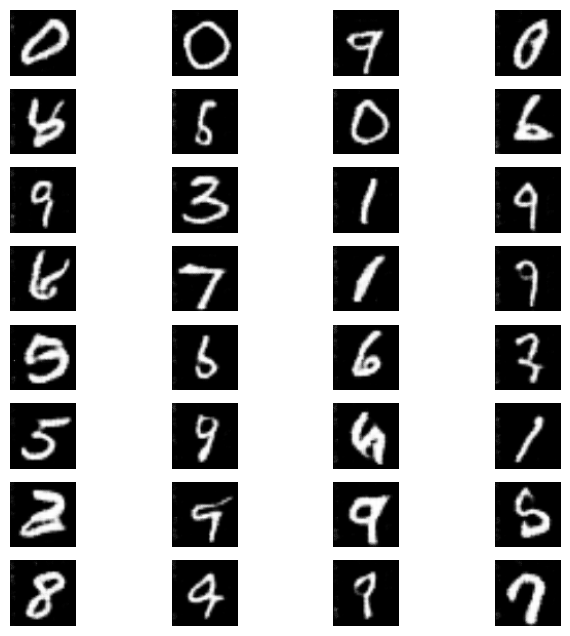

In [44]:
import matplotlib.pyplot as plt
import numpy as np

gen.eval() # Set the generator to evaluation mode

with torch.no_grad():
    # Generate a batch of fake images from the fixed noise
    fake_images = gen(fixed_noise).cpu()

# Denormalize the images
fake_images = fake_images * 0.5 + 0.5

# Convert to numpy array and change shape for plotting (N, C, H, W) -> (N, H, W, C)
fake_images = fake_images.permute(0, 2, 3, 1).numpy()

# Plot the generated images
fig = plt.figure(figsize=(8, 8))
for i in range(fake_images.shape[0]):
    plt.subplot(8, 4, i + 1)
    plt.imshow(fake_images[i].squeeze(), cmap='gray') # Use squeeze for grayscale images
    plt.axis("off")
plt.show()